# Recreating Results from Heneka et al. 2017

### Tyler Cox

This notebook has been created to recreate the results from [Heneka et. al 2017](https://arxiv.org/pdf/1611.09682.pdf). In this paper, authors showed how cross-correlation of cosmological Ly$\alpha$ and 21cm emission could potential be used as a probe of reionization. In their analysis, they used simulated Ly$\alpha$ and 21cm data created by 21cmFAST along with instrument effects from Ly$\alpha$ probes (SPHEREx and CDIM) and a 21cm probe (SKA Low). I will use their process to simulate SPHEREx and HERA cross-correlation.

## 21cmFAST

Parameters:

$w = -1$, $\Omega_m = 0.32$, $\Omega_K = 0$, $\Omega_b = 0.049$,

$h = 0.67$, $\sigma_8 = 0.83$, $n_s = 0.96$, $\Omega_r = 8.6 \times 10^{-5}$,

$N_{eff} = 3.046$, $Y_{He} = 0.24$, $R_{mfp}^{UV} = 40$ Mpc, $T_{vir} = 10^4 K$

$\zeta_x = 10^{56}$, $f_* = 0.1$, $\zeta = 10$

Box Size: 200 Mpc $\times$ 200 Mpc

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import twentyonecmfast_tools
import sys
import matplotlib.colors as colors
from scipy.signal import correlate2d
from astropy.cosmology import WMAP9 as cosmo

plt.rc('font', family='serif')

In [2]:
def load_binary_data(filename, dtype=np.float32): 
    """ 
    We assume that the data was written 
    with write_binary_data() (little endian). 
    """ 
    f = open(filename, "rb")
    data = f.read()
    f.close()
    _data = np.frombuffer(data, dtype)
    if sys.byteorder == 'big':
        _data = _data.byteswap()
    return _data

## Helpful Functions

In [3]:
def H(z, h = 0.68, Om = 0.31, Ol = 0.69, Ok = 0.0):
    '''
    
    Returns the Hubble parameter at a given redshift
    
    Units: km s^-1 Mpc^-1
    
    '''
    H0 = h*100
    return np.sqrt(H0**2 * (Om*(1+z)**3+Ok*(1+z)**2+Ol))

### Calculating a virial radius for a virial halo of mass $M_{vir}$

$$M_{vir} \approx \frac{4}{3}\pi r_{vir}^3 \cdot 200 \rho_{crit}$$

$$r_{vir} \approx \left(\frac{3 M_{vir}}{800 \pi \rho_{crit}} \right) ^{\frac{1}{3}}$$

In [4]:
def vir_rad(M,z):
    '''
    Approximates the virial radius for a halo of a certain virial mass
    
    Probably not a great estimatation better to use halo radius generated by 21cmFAST
    
    '''
    return (3.0*M/(800.0*np.pi*crit_density(z)))**(1.0/3.0)

def crit_density(z, G = 4.302e-9):
    '''
    Function to calculate critical density
    
    G = 4.302e-9 Mpc M_sun^-1 (km/s)^2
    
    Return Units: M_sun Mpc^-3
    
    '''
    return 3.0*H(z)**2/(8.0*np.pi*G)

def y(z, l = 2.46e-18):
    '''
    
    l = 2.46e-18 km
    
    Return Units: Mpc s
    
    '''
    return l*(1+z)**2/H(z)    

def SFR(M, a = 2.8, b = -0.94, c1 = 1e9, c2 = 7e10, d = -1.7):
    '''
    Returns an approximate star-formation rate for a halo of a given mass
    
    http://iopscience.iop.org/article/10.1088/0004-637X/763/2/132/pdf
    
    '''
    return (2.8e-28 * (M**a) * (1+M/c1)**b * (1 + M/c2)**d)

def f_lya(z, C_dust = 3.34, zeta = 2.57):
    '''
    Fraction of lyman-alpha photons not absorbed by dust
    '''
    return C_dust*(1+z)**zeta

def f_esc(M,z):
    '''
    Escape fraction of ionizing photons
    '''
    
    def alpha(z):
        '''
        Alpha/beta values found in:
        
        https://arxiv.org/pdf/0903.2045.pdf
        '''
        a_b = {10.4: (2.78e-2, 0.105),
             8.2: (1.30e-2, 0.179),
             6.7: (5.18e-3, 0.244),
             5.7: (3.42e-3, 0.262),
             5.0: (6.68e-5, 0.431),
             4.4: (4.44e-5, 0.454)}
        zs = np.array([10.4,8.2,6.7,5.7,5.0,4.4])
        idx = np.argmin(np.abs(zs-z))
        return a_b[zs[idx]]
    
    a,b = alpha(z)
    return np.exp(-a*M**b)

def smooth_halos(M,L):
    pass

def d_a(z):
    pass

# Relevant Equations

## Galactic Component

### Simulating Ly$\alpha$ Emission

$$f_{Ly\alpha}(z)=C_{dust}10^{−3}\left(1+z\right)^{\zeta}$$

$C_{dust} = 3.34$

$\zeta = 2.57$

$$f_{esc}(z) = $$

### Ly${\alpha}$ Luminosity from Excitations of the Interstellar Medium

$$L_{exc}^{gal} = f_{Ly\alpha} \left(1-f_{esc}\right) A_{He} E_{exc} \dot{N}_{ion}$$

$$\dot{N}_{ion} = Q_{ion} \times \text{SFR}$$

$Q_{ion} = 5.38 \times 10^{60} \text{\(M_\odot\)}^{-1}$  is obtained from: http://iopscience.iop.org/article/10.1088/0004-637X/763/2/132/pdf


### Ly$\alpha$ Luminosity from Recombination

$$L_{rec}^{gal} = A_{He} f_{rec} f_{Ly\alpha} \left(1-f_{esc}\right) E_{Ly\alpha} \dot{N}_{ion}$$

Still not sure about this relationship:

$$f_{rec} \approx 0.66$$

### Total Galactic Ly$\alpha$ Luminosity

$$L^{gal} \left(M,z\right) = L_{rec}^{gal}\left(M,z\right) + L_{exc}^{gal}\left(M,z\right)$$


### Luminosity to Surface Brightness

$$L^{gal} \left(\textbf{x},z\right) = y \left( z \right ) d_A^2 \left( z \right ) \frac{L^{gal} \left(\textbf{x},z\right)}{4 \pi d_L^2 \left( z \right )}$$

Supposedly,

$$d_L\left( z \right ) = \left(1+z \right)^2 d_A \left( z \right )$$

And,

$$ y \left( z \right ) = \lambda_0 \frac{\left(1+z \right)^2}{H \left( z \right )}$$

So,

$$I_{\nu}^{gal} \left(\textbf{x},z\right) = \frac{\lambda_0  L^{gal} \left(\textbf{x},z\right)}{4 \pi \left(1+z \right)^2 H \left( z \right )}$$

In [89]:
def L_gal_exc(M, z, Q_ion = 5.38e60, Y_He = 0.245, Ev = 3.429e-11):
    '''
    Lyman-alpha luminosity from excitation in the ISM
    
    E_v in ergs
    
    Return Units: ergs/year
    
    
    '''
    A_He = (4.0-Y_He)/(4.0-3*Y_He)
    E_exc = Ev*0.1
    
    return f_lya(z)*(1-f_esc(M,z))*A_He*E_exc*Q_ion*SFR(M)

def L_gal_rec(M, z, Q_ion = 5.38e60, Y_He = 0.245, E_lya = 1.637e-11, f_rec = 0.66):
    '''
    Lyman-alpha luminosity from excitation in the ISM
    
    E_lya units in ergs
    
    Return Units: ergs/year
    '''
    A_He = (4.0-Y_He)/(4.0-3*Y_He)
    
    return A_He*f_rec*f_lya(z)*(1-f_esc(M,z))*E_lya*Q_ion*SFR(M)

def L_gal(L_rec, L_exc):
    '''
    Total galactic lya luminosity. Pass in output from L_rec and L_exc, which are in units of ergs/year
    
    Return Units: ergs/s
    '''
    
    sec_per_year = 60.0*60.0*24*365.0
    
    return (L_rec+L_exc)/sec_per_year

def Lgal_to_I(L, R, z, l = 2.46e-18):
    '''
    Convert Luminosity (not luminosity density) to Surface Brightness for a halo of a given mass and redshift
    
    L -> luminosity of the halo in ergs/s
    R -> Virial radius of the halo Mpc
    l -> Rest frame wavelength of Lya (2.46e-18 km)
    
    Return Units: erg cm^-2 sr^-1
    '''
    
    L /= R**3
    
    Mpc_to_cm = 3.086e15
    
    I = l * L / (4 * np.pi * H(z) * (1+z)**2)
    
    return I/(Mpc_to_cm**2)

In [6]:
halos = np.genfromtxt('21cmFAST/Output_files/Halo_lists/halos_z7.04_768_200Mpc')
idxs = np.where((0.50001 > halos[:,3]) & (halos[:,3] > 0.49999))[0]
len(idxs)

5380

In [7]:
halo_rad = np.genfromtxt('21cmFAST/Output_files/Halo_lists/halos_radii_z7.04_768_200Mpc')

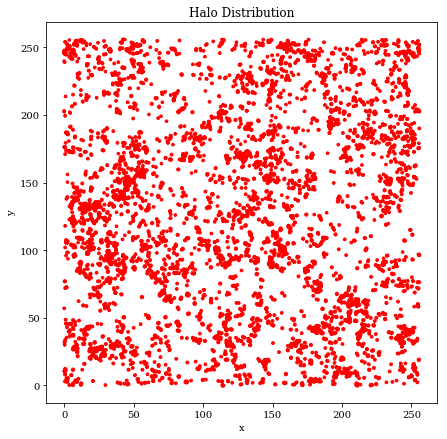

In [12]:
plt.figure(figsize=(14,7))
plt.title('Halo Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(halos[idxs,2]*256,halos[idxs,1]*256 , c='r',s=halo_rad/halo_rad.max()*20)
plt.show()

In [88]:
halo_lum = []
halo_I = []
z = 7.04

for m in halos[idxs,0]:
    halo_lum.append(L_gal(L_gal_exc(m,z), L_gal_rec(m,z)))

for i, r in enumerate(halo_rad[idxs]):
    halo_I.append(Lgal_to_I(halo_lum[i], r, z))

<type 'numpy.float64'>


TypeError: 'numpy.float64' object is not callable

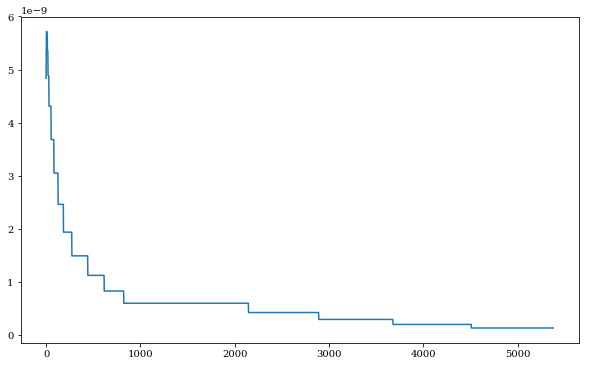

In [41]:
plt.figure(figsize=(10,6))
plt.plot(halo_I)
plt.show()

In [42]:
np.sum(halo_I[:100])

4.199743390975464e-07

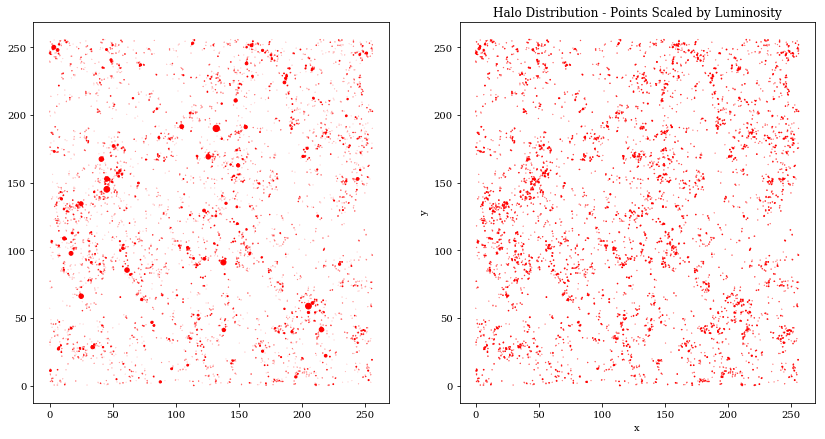

In [49]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.scatter(halos[idxs,2]*256,halos[idxs,1]*256 , c='r',s=halo_lum/max(halo_lum)*40)
plt.subplot(1,2,2)
plt.scatter(halos[idxs,2]*256,halos[idxs,1]*256 , c='r',s=halo_I/max(halo_I)*2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Halo Distribution - Points Scaled by Luminosity')
plt.show()

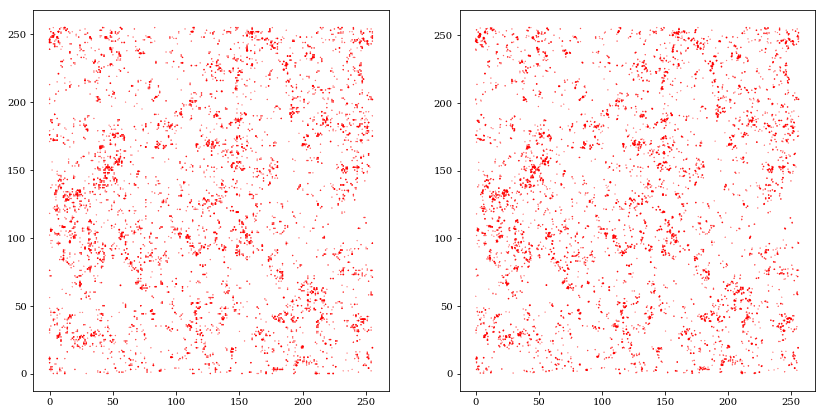

In [63]:
halo_x = (halos[idxs,2]*256).astype(int)
halo_y = (halos[idxs,1]*256).astype(int)

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.scatter(halo_x, halo_y,  c='r',s=halo_I/max(halo_I)*2)
plt.subplot(1,2,2)
plt.scatter(halos[idxs,2]*256,halos[idxs,1]*256 , c='r',s=halo_I/max(halo_I)*2)
plt.show()

In [54]:
L_exc = []
L_rec = []
L_tot = []

I_tot = []

for m in halos[idxs,0]:
    L_exc.append(L_gal_exc(m,z)/(24*60.0*60.0*365.0))
    L_rec.append(L_gal_rec(m,z)/(24*60.0*60.0*365.0))
    L_tot.append(L_gal(L_gal_exc(m,z), L_gal_rec(m,z)))

for i, r in enumerate(halo_rad[idxs]):
    I_tot.append(Lgal_to_I(L_tot[i], r, z))

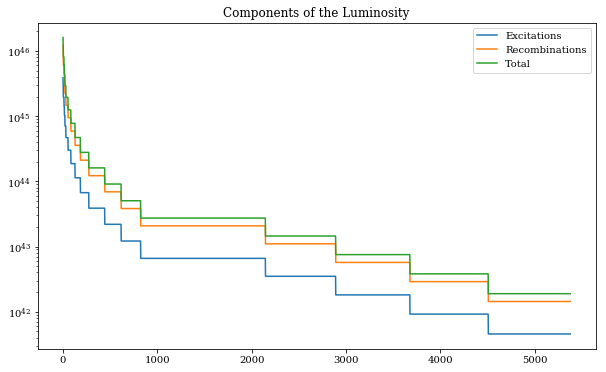

In [55]:
plt.figure(figsize=(10,6))
plt.plot(L_exc,label='Excitations')
plt.plot(L_rec,label='Recombinations')
plt.plot(L_tot,label='Total')
plt.yscale('log')
plt.title('Components of the Luminosity')
plt.legend()
plt.show()

In [70]:
halo_x = (halos[idxs,2]*256).astype(int)
halo_y = (halos[idxs,1]*256).astype(int)

gal_lya = np.zeros((256,256))

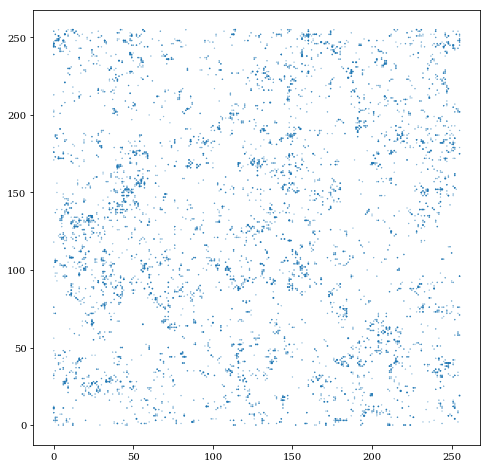

In [79]:
plt.figure(figsize=(8,8))
plt.scatter(halo_x, halo_y,s=halo_I/max(halo_I)*2)
plt.show()

In [71]:
for i in np.arange(halo_x.shape[0]):
    gal_lya[halo_x[i]][halo_y[i]] += I_tot[i]

/data4/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


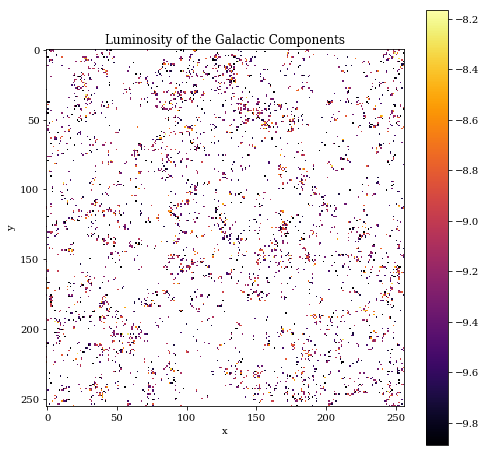

In [72]:
plt.figure(figsize=(8,8))
plt.imshow(np.log10(gal_lya), cmap=plt.cm.inferno)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Luminosity of the Galactic Components')
plt.colorbar()
plt.show()

## Compare Galaxy Map to Differential Brightness Temperature

In [16]:
f = 'runs/full_run_1/Boxes/delta_T_v3_z007.04_nf0.233584_useTs1_256_200Mpc'
dTb = load_binary_data(f)
dTb = dTb.reshape((256,256,256))[:,:,128]

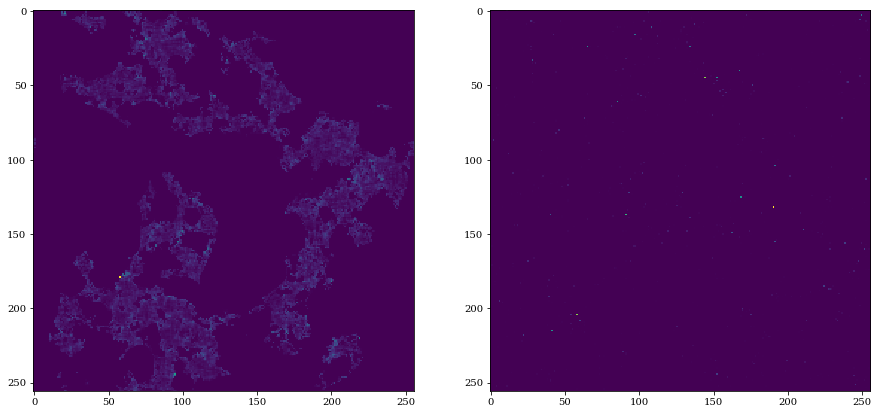

In [17]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(dTb/dTb.max())
plt.subplot(1,2,2)
plt.imshow(gal_lya/gal_lya.max())

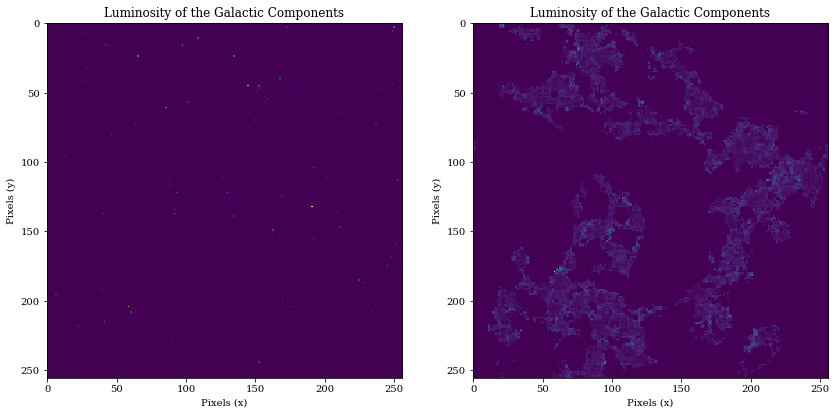

In [19]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(gal_lya/gal_lya.max())
plt.xlabel('Pixels (x)')
plt.ylabel('Pixels (y)')
plt.title('Luminosity of the Galactic Components')


plt.subplot(1,2,2)
plt.imshow(dTb)
plt.xlabel('Pixels (x)')
plt.ylabel('Pixels (y)')
plt.title('Luminosity of the Galactic Components')
plt.show()

## IGM Component

### IGM Ly$\alpha$ Luminosity Density Due to Recombination

$$l^{IGM}_{rec} = f_{rec} \dot{n}_{rec}(x,z) E_{Ly\alpha}$$

$$\dot{n}_{rec}(x,z) = \alpha_A n_e(z) n_{HII}(z)$$

$$n_e(z) = x_i n_b$$

$$ n_{HII}(z) = x_i n_b \left(4-4Y_{He} \right)/ \left( 4-3 Y_{He} \right) $$

In [20]:
def l_igm_rec(n_rec_slice, f_rec = 0.66, E_lya = 1.637e-11):
    '''
    E_lya units in ergs
    '''
    return f_rec*n_rec_slice*E_lya

In [21]:
xi = load_binary_data('21cmFAST/Boxes/xH_z007.04_nf0.233584_Fstar0.0500_starPL0.5000_Fesc0.1000_escPL-0.5000_Mturn5.00e+08_HIIfilter1_RHIImax50_256_200Mpc')
xi_frac = 1-xi.mean()

dx = load_binary_data('21cmFAST/Boxes/updated_smoothed_deltax_z007.04_256_200Mpc')
dx = np.reshape(dx, (256,256,256))

In [22]:
temp_gas = load_binary_data('21cmFAST/Boxes/Ts_z007.04_L_X3.2e+40_alphaX1.0_f_star0.0500_alpha_star0.5000_f_esc0.1000_alpha_esc-0.5000_Mturn5.0e+08_t_star0.5000_Pop2_256_200Mpc')
temp_gas = np.reshape(temp_gas, (256,256,256))

In [23]:
Y_He = 0.245
A_He = (4.0-4*Y_He)/(4.0-3*Y_He)
alpha = 4.2e-13*(temp_gas[:,:,128]/10**4)**(0.7)*(1+z)**3

n_rec_slice = alpha*(dx.mean()**2)*(xi_frac**2)*(A_He)

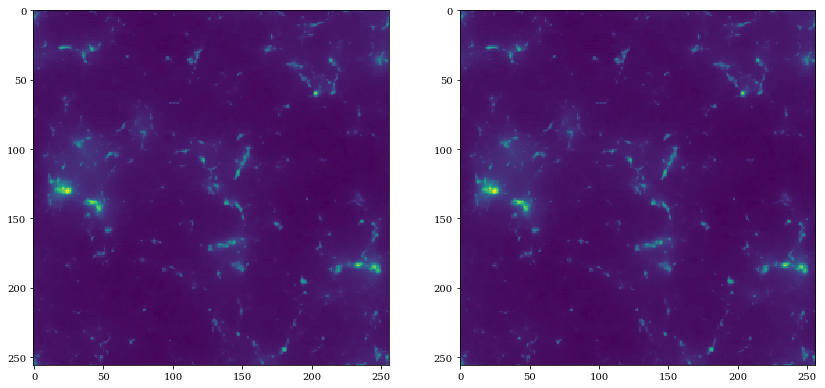

In [24]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(alpha)
plt.subplot(1,2,2)
plt.imshow(n_rec_slice)
plt.show()

/data4/tcox/src/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


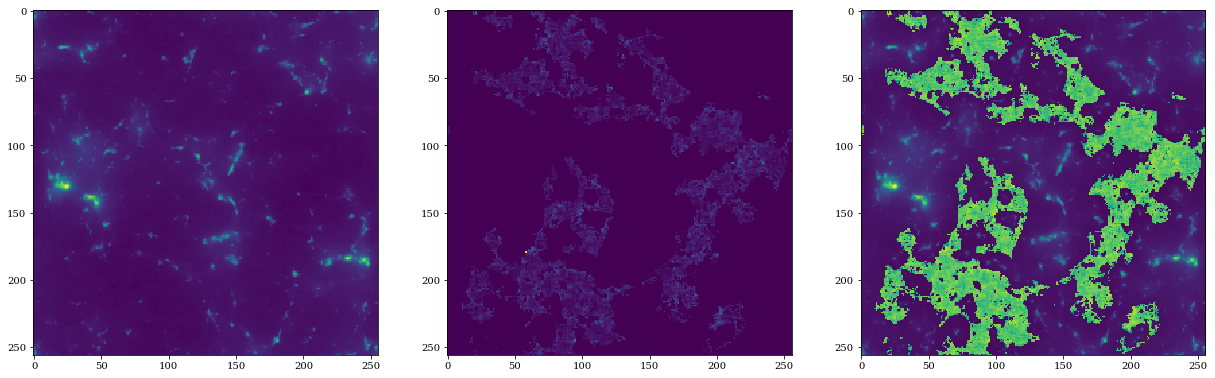

In [71]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
plt.imshow(n_rec_slice)
plt.subplot(1,3,2)
plt.imshow(temp_data)

plt.subplot(1,3,3)
plt.imshow(n_rec_slice)
plt.imshow(np.log10(temp_data))
plt.show()

In [75]:
np.corrcoef(temp_data.flatten(),n_rec_slice.flatten())

array([[ 1.        , -0.22565133],
       [-0.22565133,  1.        ]])

In [25]:
plt.figure(figsize=(7,7))
plt.imshow(l_igm_rec(n_rec_slice)+gaussian_filter(gal_lya/10e90,1.7/200*256).T)
plt.colorbar()
plt.show()

NameError: name 'gaussian_filter' is not defined

## Image Smoothing

Angular resolution of HERA is given by:

$$\theta = 1.22 \frac{\lambda}{D}$$

Both $\lambda$ and $D$ in units of meters and $\theta$ is in units of arcseconds

HERA's longest baseline is roughly 870 m

In [90]:
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import SymLogNorm

In [91]:
img = np.zeros((100,100))
img[40:45, 80:90] += 10
img[20:30, 10:20] += 10
img[60:70, 40:50] += 10

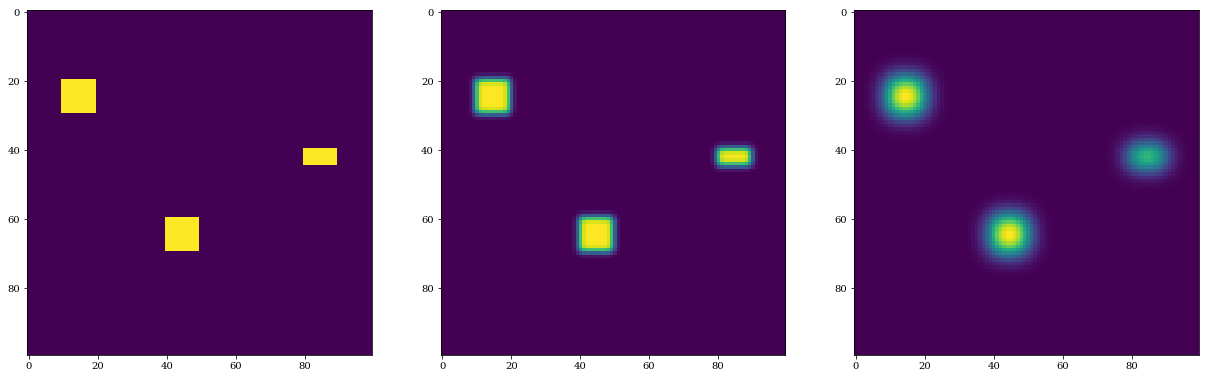

In [92]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
plt.imshow(img)

plt.subplot(1,3,2)
plt.imshow(gaussian_filter(img,1))

plt.subplot(1,3,3)
plt.imshow(gaussian_filter(img,3))

plt.show()

In [138]:
halos = np.genfromtxt('21cmFAST/Output_files/Halo_lists/halos_z9.40_768_200Mpc')
idxs = np.where((0.50001 > halos[:,3]) & (halos[:,3] > 0.49999))[0]

halo_lum = []
halo_I = []
z = 9.40

for m in halos[idxs,0]:
    halo_lum.append(L_gal(L_gal_exc(m,z), L_gal_rec(m,z)))

for i, r in enumerate(halo_rad[idxs]):
    halo_I.append(Lgal_to_I(halo_lum[i], r, z))

In [139]:
L_exc = []
L_rec = []
L_tot = []

I_tot = []

for m in halos[idxs,0]:
    L_exc.append(L_gal_exc(m,z)/(24*60.0*60.0*365.0))
    L_rec.append(L_gal_rec(m,z)/(24*60.0*60.0*365.0))
    L_tot.append(L_gal(L_gal_exc(m,z), L_gal_rec(m,z)))

for i, r in enumerate(halo_rad[idxs]):
    I_tot.append(Lgal_to_I(L_tot[i], r, z))

In [140]:
halo_x = (halos[idxs,2]*256).astype(int)
halo_y = (halos[idxs,1]*256).astype(int)

gal_lya = np.zeros((256,256))

for i in np.arange(halo_x.shape[0]):
    gal_lya[halo_x[i],halo_y[i]] += I_tot[i]

/data4/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


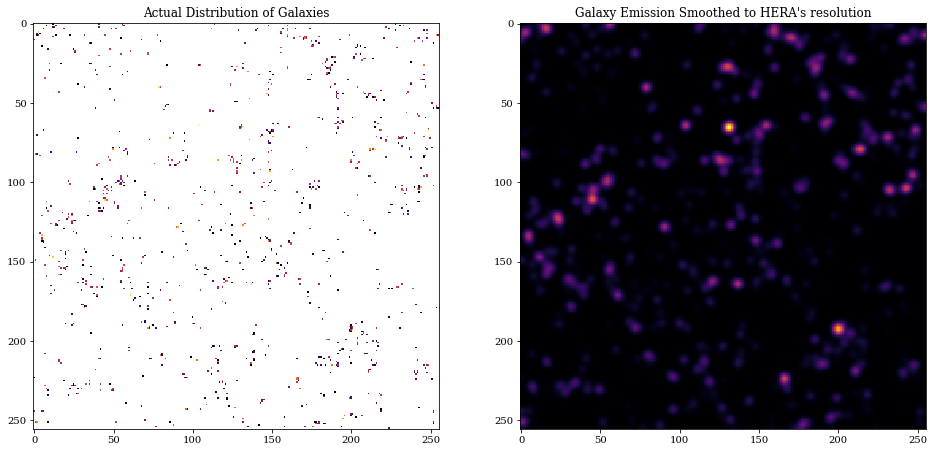

In [141]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(np.rot90(np.log10(gal_lya)), cmap=plt.cm.inferno)
plt.title('Actual Distribution of Galaxies')

plt.subplot(1,2,2)
plt.title("Galaxy Emission Smoothed to HERA's resolution")
plt.imshow(np.rot90(gaussian_filter(gal_lya,1.7/200*256)), cmap=plt.cm.inferno)
plt.show()

In [144]:
temp_data = load_binary_data('21cmFAST/Boxes/delta_T_v3_z009.40_nf0.835939_useTs1_256_200Mpc')
temp_3d = np.reshape(temp_data,(256,256,256))

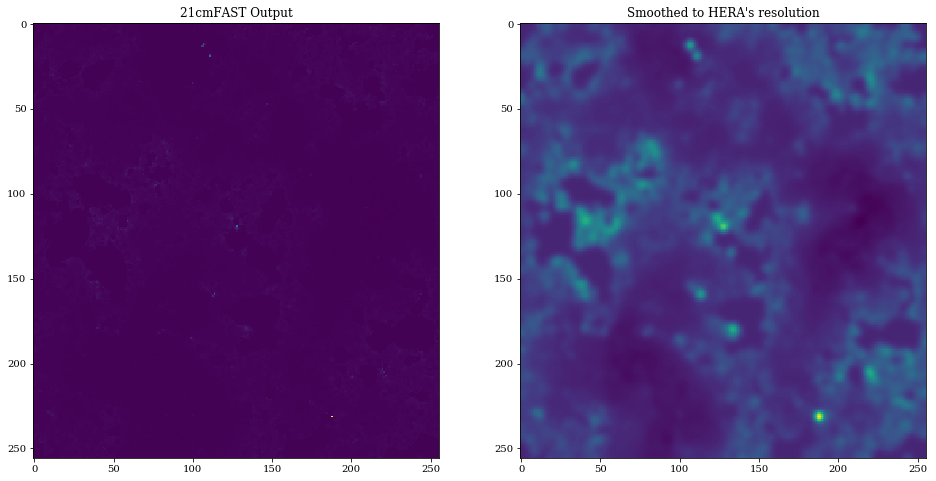

In [145]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title('21cmFAST Output')
plt.imshow(temp_3d[:,:,128],aspect='auto')

plt.subplot(1,2,2)
plt.title("Smoothed to HERA's resolution")
plt.imshow(gaussian_filter(temp_3d[:,:,128],1.7/200*256),aspect='auto')

plt.show()

/data4/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/data4/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


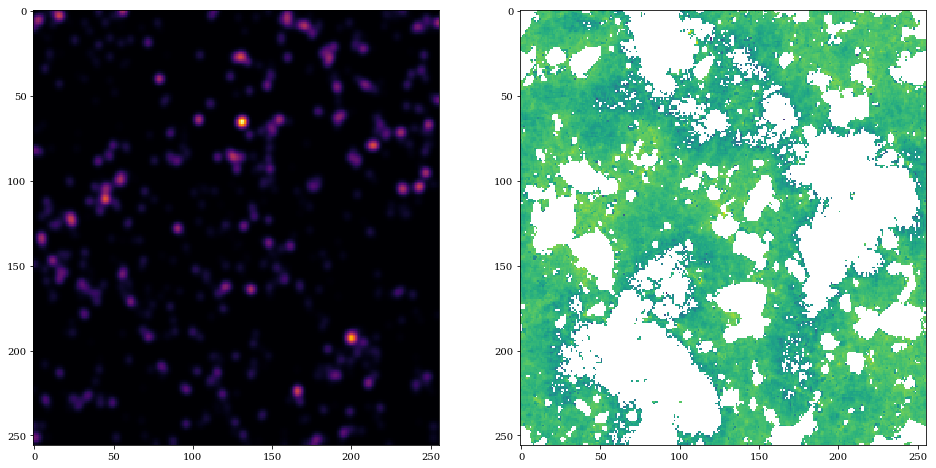

In [147]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(np.rot90(gaussian_filter(gal_lya,1.7/200*256)),aspect='auto', cmap=plt.cm.inferno)
#plt.imshow(np.log(temp_3d[:,:,128]),aspect='auto')

plt.subplot(1,2,2)
#plt.imshow(gaussian_filter(gal_lya,1.7/200*256),aspect='auto')
plt.imshow(np.log(temp_3d[:,:,128]),aspect='auto')

plt.show()

In [57]:
np.corrcoef(lya_lum.flatten(), temp_data.flatten())

array([[1.        , 0.00531287],
       [0.00531287, 1.        ]])

/data4/tcox/src/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


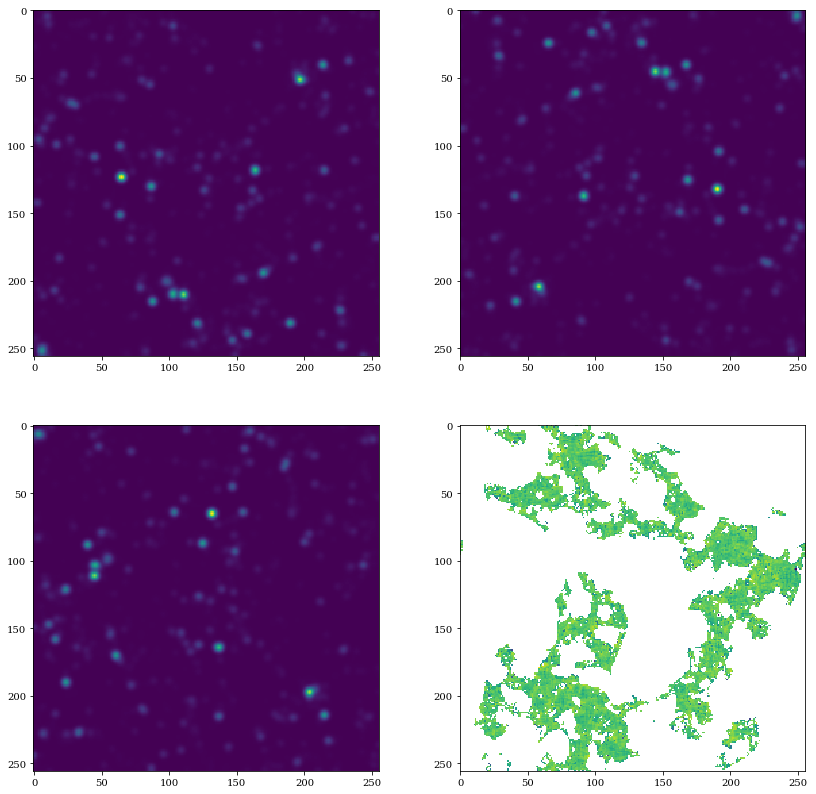

In [64]:
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
plt.imshow(lya_lum)
plt.subplot(2,2,2)
plt.imshow(np.rot90(lya_lum,k=2))
plt.subplot(2,2,3)
plt.imshow(np.rot90(lya_lum,k=3))
plt.subplot(2,2,4)
plt.imshow(np.log10(temp_data))

In [65]:
for i in np.arange(4):
    print np.corrcoef(temp_data.flatten(),np.rot90(lya_lum,k=i).flatten())

[[1.         0.00531287]
 [0.00531287 1.        ]]
[[1.        0.0091529]
 [0.0091529 1.       ]]
[[1.         0.04231577]
 [0.04231577 1.        ]]
[[ 1.         -0.04323914]
 [-0.04323914  1.        ]]


In [68]:
np.corrcoef(temp_data.flatten(),np.flip(lya_lum,0).flatten())

array([[ 1.        , -0.01969916],
       [-0.01969916,  1.        ]])

21cmFAST/Boxes/delta_T_v3_z006.00_nf0.025588_useTs1_256_200Mpc


/data4/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


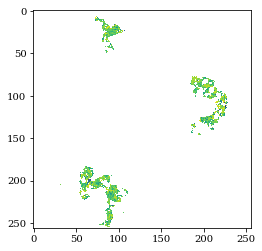

21cmFAST/Boxes/delta_T_v3_z006.14_nf0.038706_useTs1_256_200Mpc


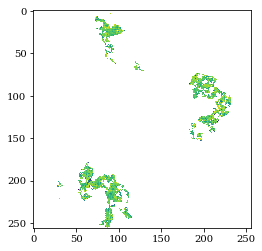

21cmFAST/Boxes/delta_T_v3_z006.28_nf0.057758_useTs1_256_200Mpc


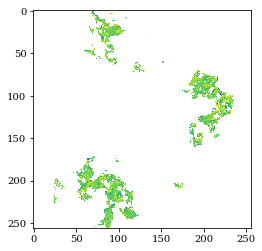

21cmFAST/Boxes/delta_T_v3_z006.43_nf0.081770_useTs1_256_200Mpc


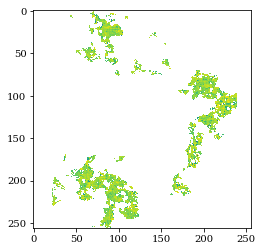

21cmFAST/Boxes/delta_T_v3_z006.58_nf0.112312_useTs1_256_200Mpc


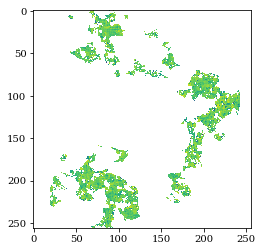

21cmFAST/Boxes/delta_T_v3_z006.73_nf0.147929_useTs1_256_200Mpc


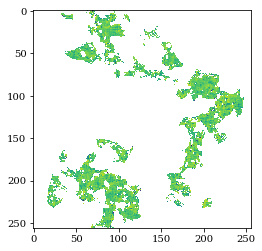

21cmFAST/Boxes/delta_T_v3_z006.88_nf0.188225_useTs1_256_200Mpc


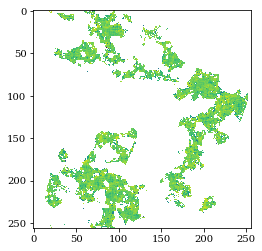

21cmFAST/Boxes/delta_T_v3_z007.04_nf0.233584_useTs1_256_200Mpc


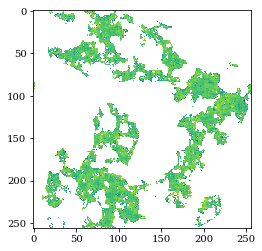

21cmFAST/Boxes/delta_T_v3_z007.20_nf0.283460_useTs1_256_200Mpc


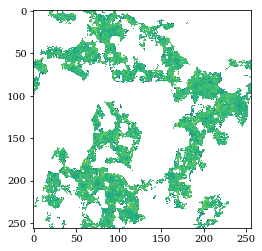

21cmFAST/Boxes/delta_T_v3_z007.37_nf0.336467_useTs1_256_200Mpc


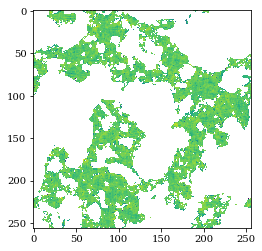

21cmFAST/Boxes/delta_T_v3_z007.53_nf0.391640_useTs1_256_200Mpc


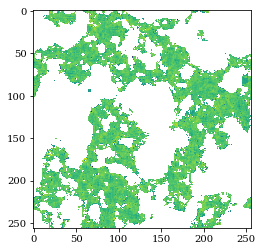

21cmFAST/Boxes/delta_T_v3_z007.70_nf0.446992_useTs1_256_200Mpc


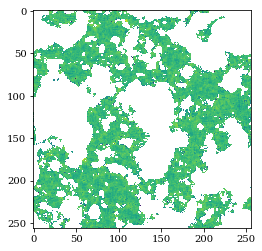

21cmFAST/Boxes/delta_T_v3_z007.88_nf0.501314_useTs1_256_200Mpc


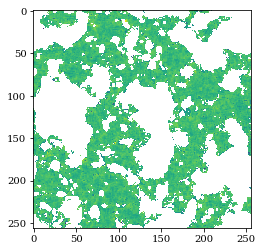

21cmFAST/Boxes/delta_T_v3_z008.06_nf0.553432_useTs1_256_200Mpc


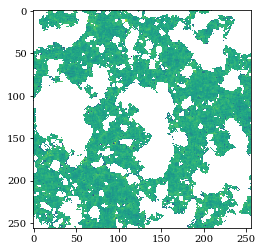

21cmFAST/Boxes/delta_T_v3_z008.24_nf0.603302_useTs1_256_200Mpc


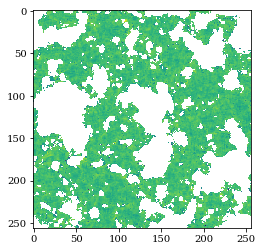

21cmFAST/Boxes/delta_T_v3_z008.42_nf0.650315_useTs1_256_200Mpc


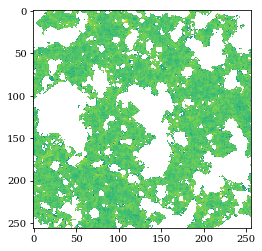

21cmFAST/Boxes/delta_T_v3_z008.61_nf0.694463_useTs1_256_200Mpc


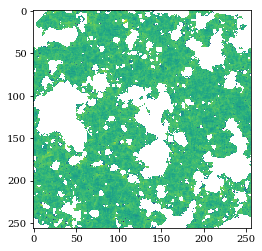

21cmFAST/Boxes/delta_T_v3_z008.80_nf0.735219_useTs1_256_200Mpc


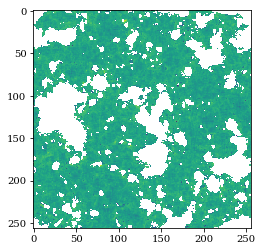

21cmFAST/Boxes/delta_T_v3_z009.00_nf0.772479_useTs1_256_200Mpc


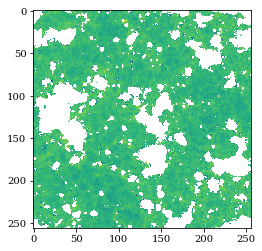

21cmFAST/Boxes/delta_T_v3_z009.20_nf0.806082_useTs1_256_200Mpc


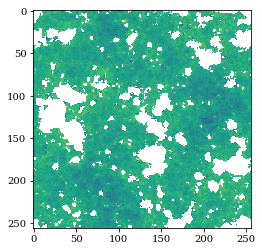

21cmFAST/Boxes/delta_T_v3_z009.40_nf0.835939_useTs1_256_200Mpc


/data4/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


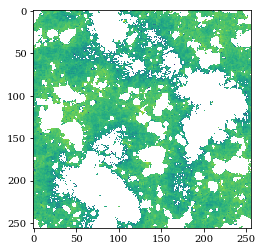

21cmFAST/Boxes/delta_T_v3_z009.61_nf0.862289_useTs1_256_200Mpc


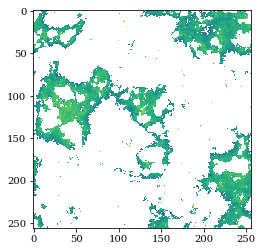

21cmFAST/Boxes/delta_T_v3_z009.82_nf0.885206_useTs1_256_200Mpc


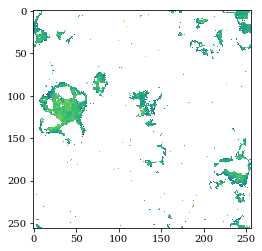

21cmFAST/Boxes/delta_T_v3_z010.04_nf0.905037_useTs1_256_200Mpc


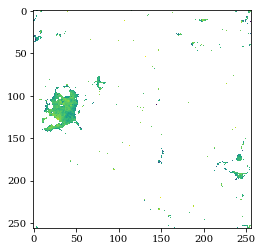

21cmFAST/Boxes/delta_T_v3_z010.26_nf0.922049_useTs1_256_200Mpc


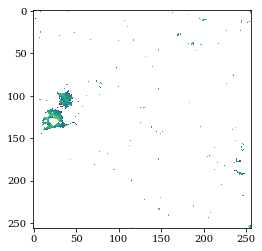

21cmFAST/Boxes/delta_T_v3_z010.49_nf0.936460_useTs1_256_200Mpc


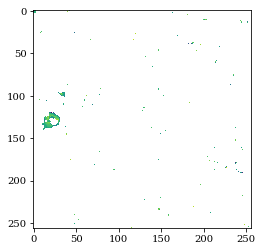

21cmFAST/Boxes/delta_T_v3_z010.71_nf0.948601_useTs1_256_200Mpc


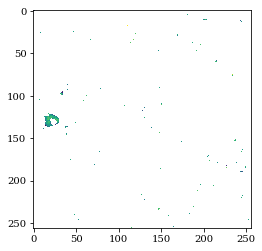

21cmFAST/Boxes/delta_T_v3_z010.95_nf0.958808_useTs1_256_200Mpc


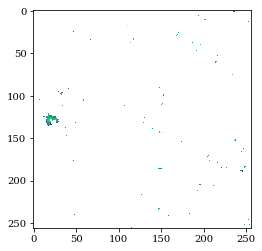

21cmFAST/Boxes/delta_T_v3_z011.19_nf0.967254_useTs1_256_200Mpc


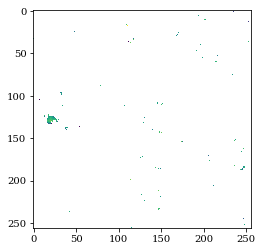

21cmFAST/Boxes/delta_T_v3_z011.43_nf0.974165_useTs1_256_200Mpc


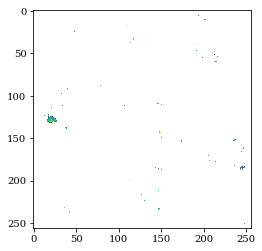

21cmFAST/Boxes/delta_T_v3_z011.68_nf0.979776_useTs1_256_200Mpc


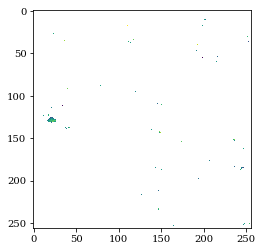

21cmFAST/Boxes/delta_T_v3_z011.93_nf0.984336_useTs1_256_200Mpc


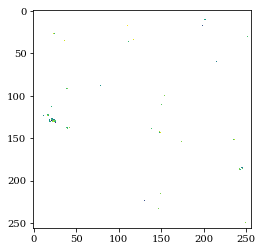

21cmFAST/Boxes/delta_T_v3_z012.19_nf0.987956_useTs1_256_200Mpc


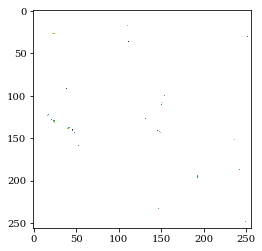

21cmFAST/Boxes/delta_T_v3_z012.46_nf0.990818_useTs1_256_200Mpc


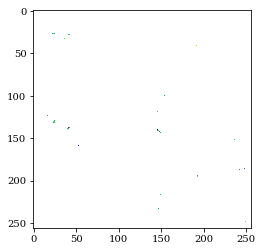

21cmFAST/Boxes/delta_T_v3_z012.73_nf0.993069_useTs1_256_200Mpc


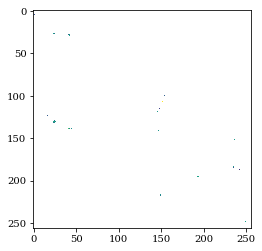

21cmFAST/Boxes/delta_T_v3_z013.00_nf0.994809_useTs1_256_200Mpc


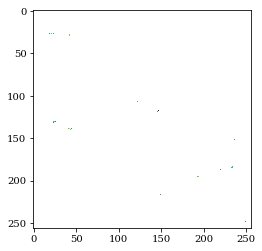

21cmFAST/Boxes/delta_T_v3_z013.28_nf0.996137_useTs1_256_200Mpc


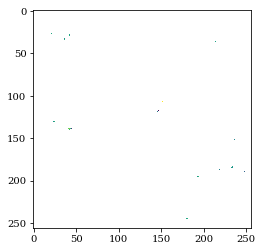

21cmFAST/Boxes/delta_T_v3_z013.57_nf0.997156_useTs1_256_200Mpc


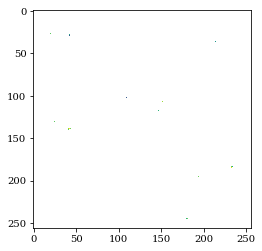

21cmFAST/Boxes/delta_T_v3_z013.86_nf0.997905_useTs1_256_200Mpc


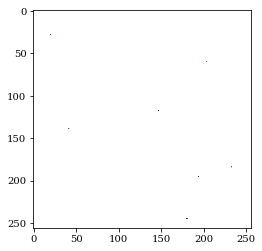

21cmFAST/Boxes/delta_T_v3_z014.15_nf0.998448_useTs1_256_200Mpc


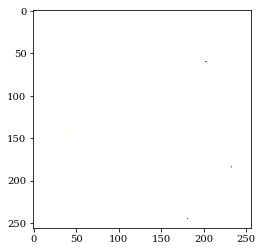

21cmFAST/Boxes/delta_T_v3_z014.46_nf0.998865_useTs1_256_200Mpc


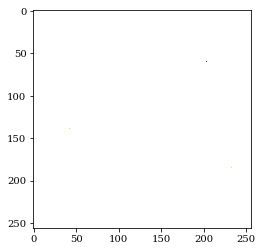

21cmFAST/Boxes/delta_T_v3_z014.77_nf0.999165_useTs1_256_200Mpc


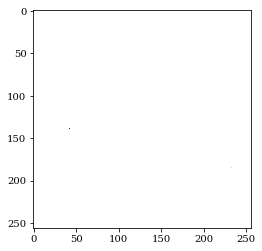

21cmFAST/Boxes/delta_T_v3_z015.08_nf0.999369_useTs1_256_200Mpc


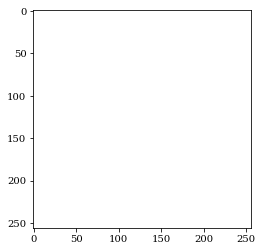

21cmFAST/Boxes/delta_T_v3_z015.40_nf0.999513_useTs1_256_200Mpc


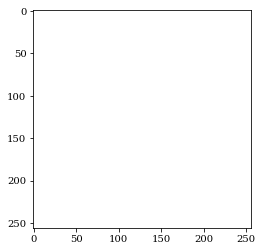

21cmFAST/Boxes/delta_T_v3_z015.73_nf0.999610_useTs1_256_200Mpc


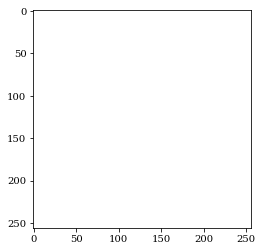

21cmFAST/Boxes/delta_T_v3_z016.07_nf0.999681_useTs1_256_200Mpc


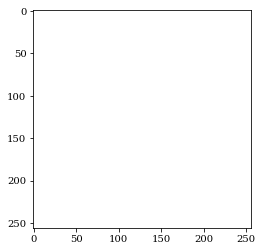

21cmFAST/Boxes/delta_T_v3_z016.41_nf0.999730_useTs1_256_200Mpc


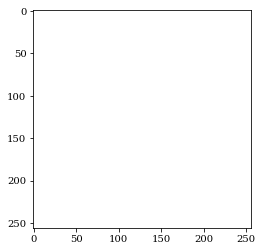

21cmFAST/Boxes/delta_T_v3_z016.76_nf0.999762_useTs1_256_200Mpc


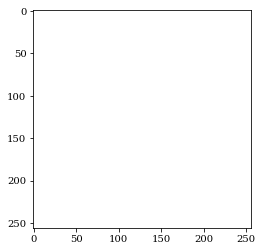

21cmFAST/Boxes/delta_T_v3_z017.11_nf0.999783_useTs1_256_200Mpc


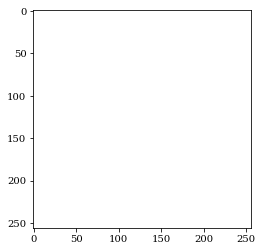

21cmFAST/Boxes/delta_T_v3_z017.47_nf0.999819_useTs1_256_200Mpc


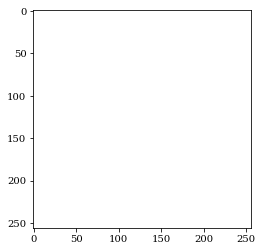

21cmFAST/Boxes/delta_T_v3_z017.84_nf0.999819_useTs1_256_200Mpc


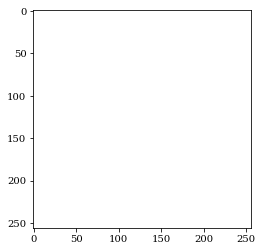

21cmFAST/Boxes/delta_T_v3_z018.22_nf0.999818_useTs1_256_200Mpc


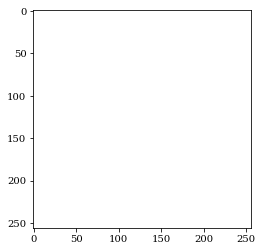

21cmFAST/Boxes/delta_T_v3_z018.60_nf0.999818_useTs1_256_200Mpc


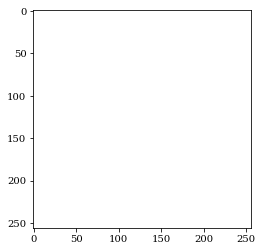

21cmFAST/Boxes/delta_T_v3_z019.00_nf0.999817_useTs1_256_200Mpc


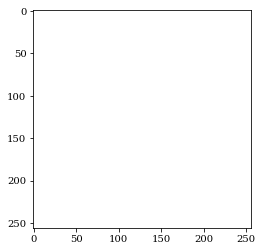

21cmFAST/Boxes/delta_T_v3_z019.40_nf0.999816_useTs1_256_200Mpc


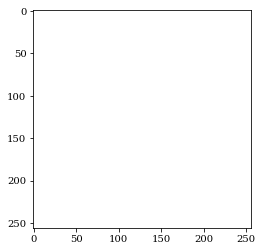

21cmFAST/Boxes/delta_T_v3_z019.80_nf0.999816_useTs1_256_200Mpc


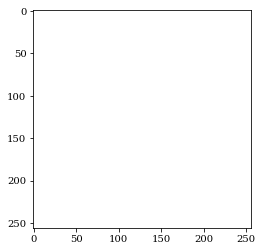

21cmFAST/Boxes/delta_T_v3_z020.22_nf0.999815_useTs1_256_200Mpc


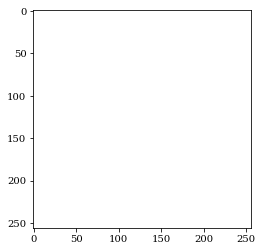

21cmFAST/Boxes/delta_T_v3_z020.64_nf0.999814_useTs1_256_200Mpc


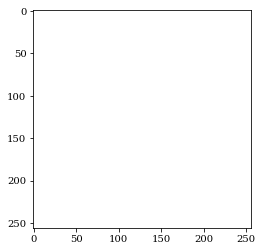

21cmFAST/Boxes/delta_T_v3_z021.08_nf0.999814_useTs1_256_200Mpc


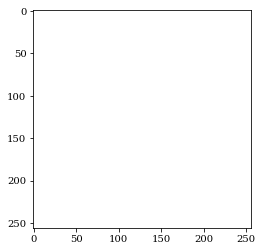

21cmFAST/Boxes/delta_T_v3_z021.52_nf0.999813_useTs1_256_200Mpc


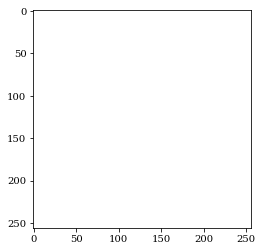

21cmFAST/Boxes/delta_T_v3_z021.97_nf0.999812_useTs1_256_200Mpc


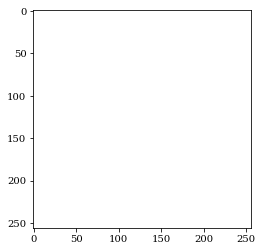

21cmFAST/Boxes/delta_T_v3_z022.43_nf0.999811_useTs1_256_200Mpc


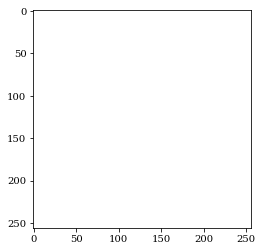

21cmFAST/Boxes/delta_T_v3_z022.90_nf0.999810_useTs1_256_200Mpc


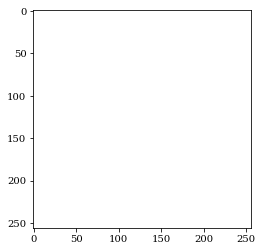

21cmFAST/Boxes/delta_T_v3_z023.38_nf0.999810_useTs1_256_200Mpc


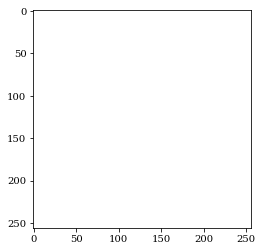

21cmFAST/Boxes/delta_T_v3_z023.86_nf0.999809_useTs1_256_200Mpc


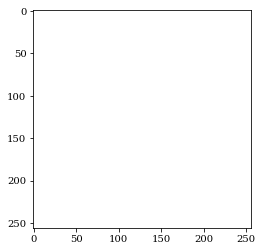

21cmFAST/Boxes/delta_T_v3_z024.36_nf0.999808_useTs1_256_200Mpc


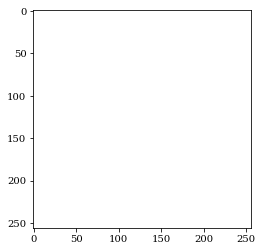

21cmFAST/Boxes/delta_T_v3_z024.87_nf0.999807_useTs1_256_200Mpc


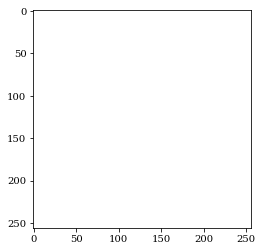

21cmFAST/Boxes/delta_T_v3_z025.38_nf0.999806_useTs1_256_200Mpc


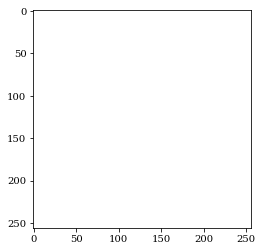

21cmFAST/Boxes/delta_T_v3_z025.91_nf0.999805_useTs1_256_200Mpc


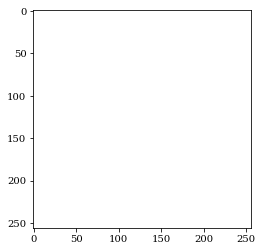

21cmFAST/Boxes/delta_T_v3_z026.45_nf0.999805_useTs1_256_200Mpc


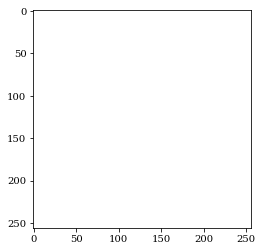

21cmFAST/Boxes/delta_T_v3_z027.00_nf0.999804_useTs1_256_200Mpc


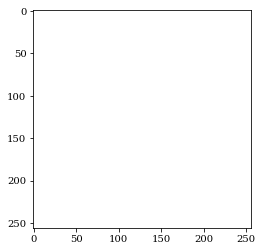

21cmFAST/Boxes/delta_T_v3_z027.56_nf0.999803_useTs1_256_200Mpc


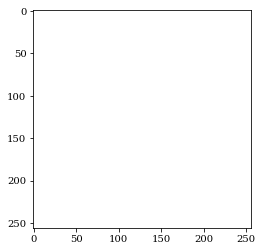

21cmFAST/Boxes/delta_T_v3_z028.13_nf0.999802_useTs1_256_200Mpc


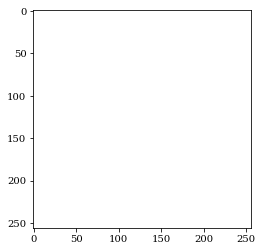

21cmFAST/Boxes/delta_T_v3_z028.71_nf0.999801_useTs1_256_200Mpc


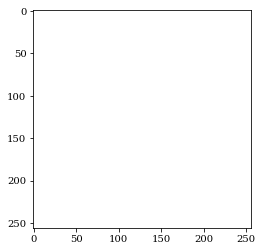

21cmFAST/Boxes/delta_T_v3_z029.31_nf0.999800_useTs1_256_200Mpc


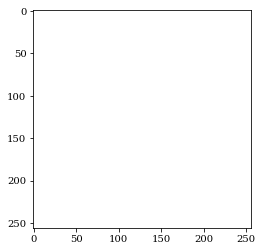

21cmFAST/Boxes/delta_T_v3_z029.91_nf0.999799_useTs1_256_200Mpc


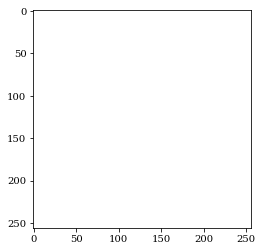

In [137]:
files = glob.glob('21cmFAST/Boxes/delta_T_v3_z*')
files.sort()

for f in files:
    print f
    temp_data = load_binary_data(f)
    temp_3d = np.reshape(temp_data,(256,256,256))
    plt.imshow(np.log10(temp_3d[:,:,128]))
    plt.show()